## Environment Setup

This section includes the importing of two key modules (cv2, pytesseract) that will be used throughout this notebook.

In [2]:
import cv2
import pytesseract
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
%matplotlib inline

def plot_images(img1, img2 = None, title1="", title2=""):
    fig = plt.figure(figsize=[30,30])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)
    
def printmd(string):
    display(Markdown(string))

print(cv2.__version__)

4.2.0


## Data Import

In [160]:
images_dir = "./frames"
image_files = os.listdir(images_dir)
image_path = "{}/{}".format(images_dir, "013.jpg")
raw = cv2.imread(image_path)

## Image Preperations

Conver the raw input image into a greayscale, this is used to help reduce the amount of pixal space we are working with, i.e greyscale is a 1x1. matrix containing pixal values between 0-255, this however needs to be improved for UK number plates as we have yeller rear plates, this yellow will need to be normalised to a factor so the edge detection can see it

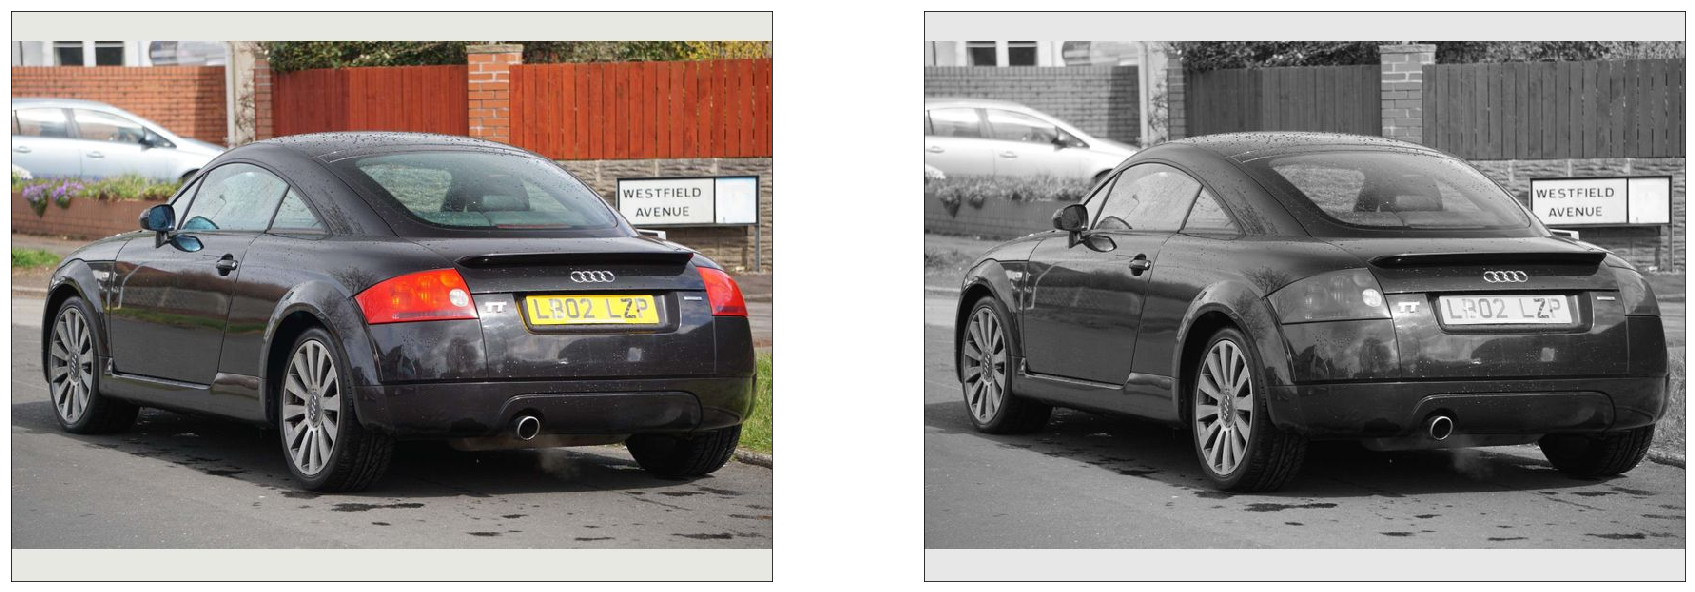

In [161]:
image = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(raw, cv2.COLOR_BGR2HSV)
plot_images(image, gray)

Here we perform a gaussian blur to help reduce the amount of noise within the pixal space, this will help increase accuracy of reads.

#### Edge Detection using Canny

Canny Edge Detection is a popular edge detection algorithm. It was developed by John F. Canny in 1986. It is a multi-stage algorithm and we will go through each stages.

##### 1. Noise Reduction

Since edge detection is susceptible to noise in the image, first step is to remove the noise in the image with a $5x5$ Gaussian filter, this filter will act as a pixal blurring agent in order to reduce the amount of noice within the image.

##### 2. Finding Intensity Gradient of the Image
Smoothened image is then filtered with a Sobel kernel in both horizontal and vertical direction to get first derivative in horizontal direction $(G_x)$ and vertical direction $(G_y)$. From these two images, we can find edge gradient and direction for each pixel as follows:

\begin{align}
Edge\_Gradient \; (G) = \sqrt{G_x^2 + G_y^2}
\end{align}
\begin{align}
Angle \; (\theta) = \tan^{-1} \bigg(\frac{G_y}{G_x}\bigg)
\end{align}

Gradient direction is always perpendicular to edges. It is rounded to one of four angles representing vertical, horizontal and two diagonal directions.

##### 3. Non-maximum Suppression
After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge. For this, at every pixel, pixel is checked if it is a local maximum in its neighborhood in the direction of gradient. Check the image below:

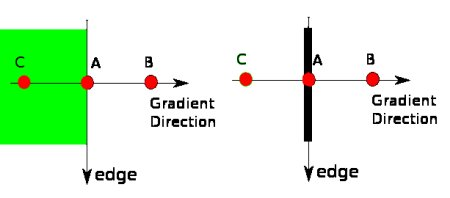

##### 4. Non-Maximum Suppression
Point A is on the edge ( in vertical direction). Gradient direction is normal to the edge. Point B and C are in gradient directions. So point A is checked with point B and C to see if it forms a local maximum. If so, it is considered for next stage, otherwise, it is suppressed ( put to zero).

In short, the result you get is a binary image with “thin edges”.

##### 5. Hysteresis Thresholding
This stage decides which are all edges are really edges and which are not. For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to “sure-edge” pixels, they are considered to be part of edges. Otherwise, they are also discarded. See the image below:

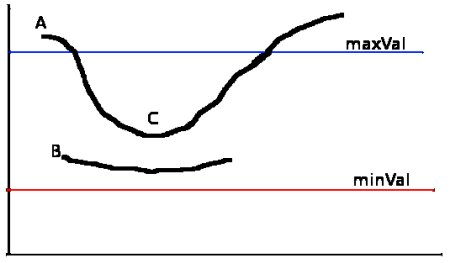

Hysteresis Thresholding
The edge A is above the maxVal, so considered as “sure-edge”. Although edge C is below maxVal, it is connected to edge A, so that also considered as valid edge and we get that full curve. But edge B, although it is above minVal and is in same region as that of edge C, it is not connected to any “sure-edge”, so that is discarded. So it is very important that we have to select minVal and maxVal accordingly to get the correct result.

This stage also removes small pixels noises on the assumption that edges are long lines.

So what we finally get is strong edges in the image.

#### Performance Notes:

1. The execution time of Gaussian blur is mostly determined by the kernel size (proportional to its linear size). The execution time is not determined by sigma. Increasing kernel size from 3x3 to 9x9 will at least triple the execution time.

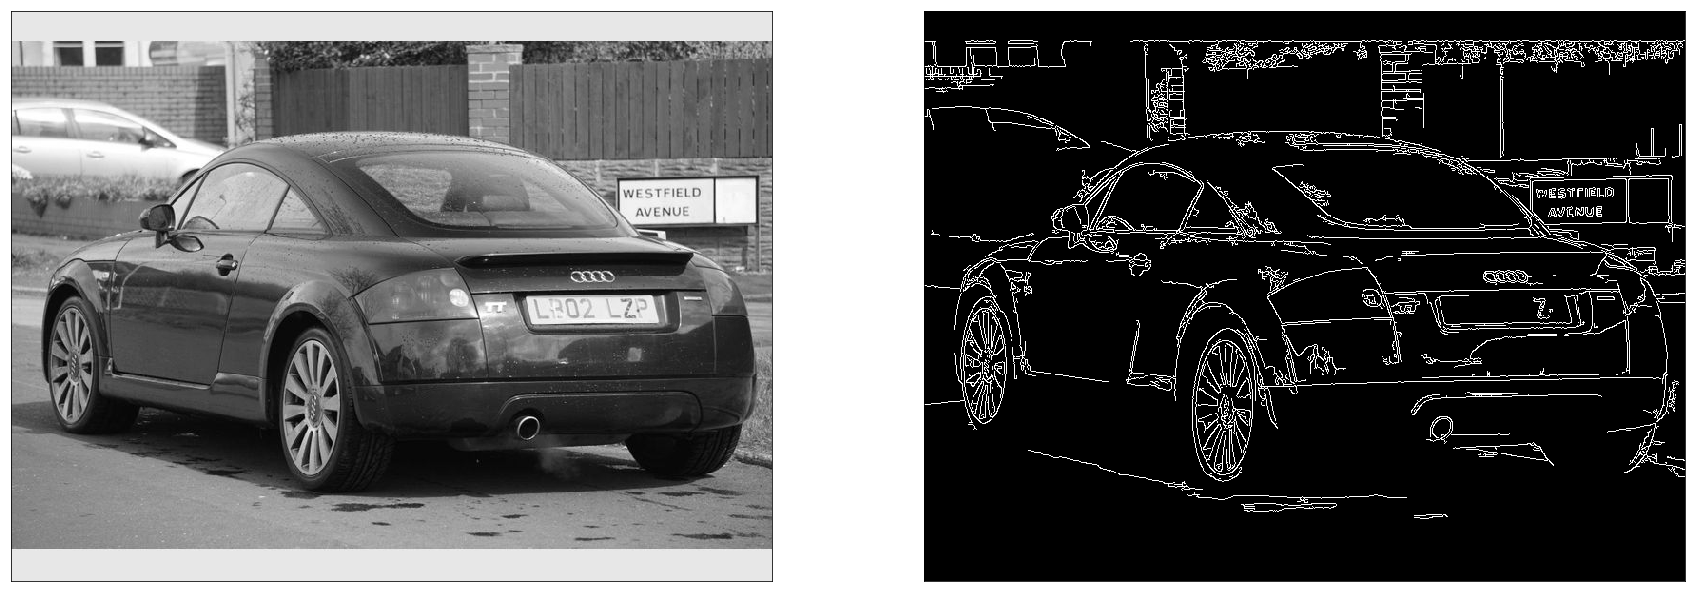

In [162]:
edges = cv2.Canny(gray, 50, 500)
plot_images(gray, edges)

## Contour Detection

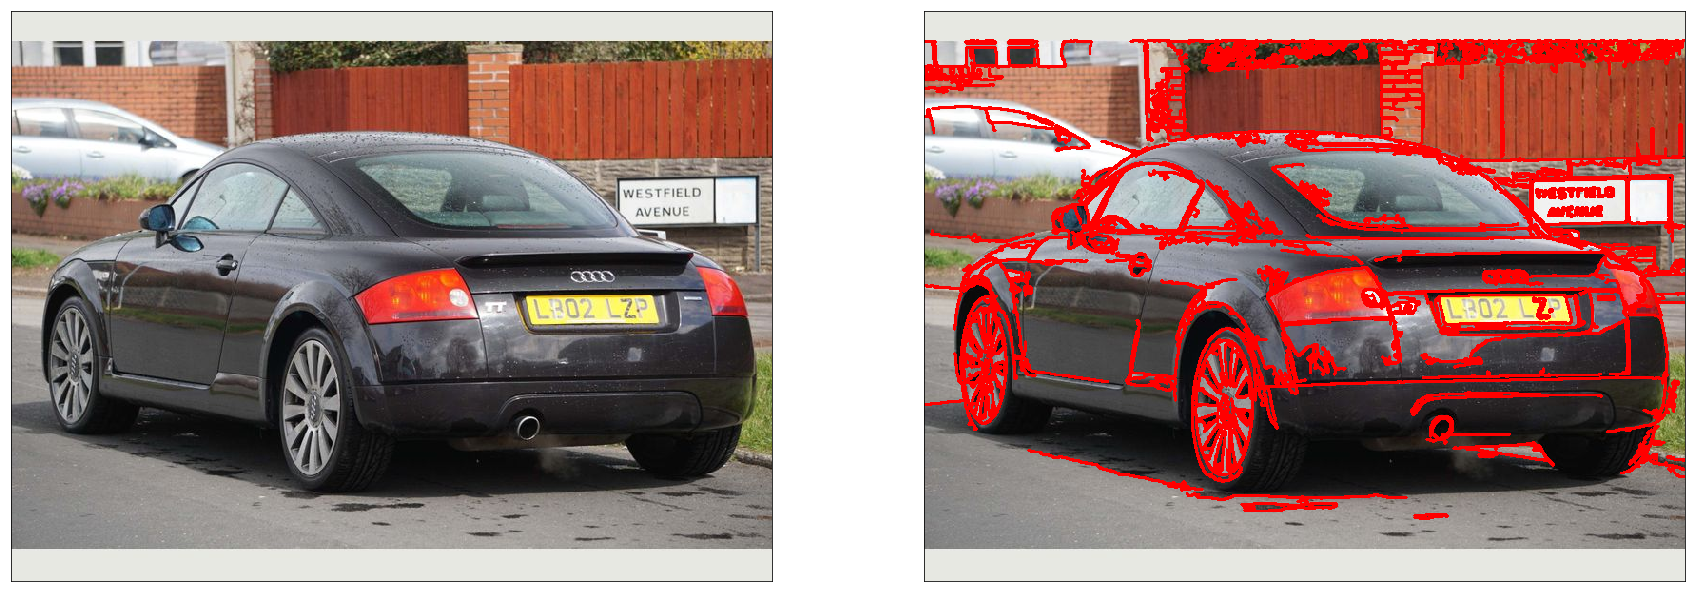

In [163]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

imag_w_contours = cv2.drawContours(image.copy(), contours, -1, 255, 2)
plot_images(image, imag_w_contours)

#### Filter contours by convex shape and ones that have four corners

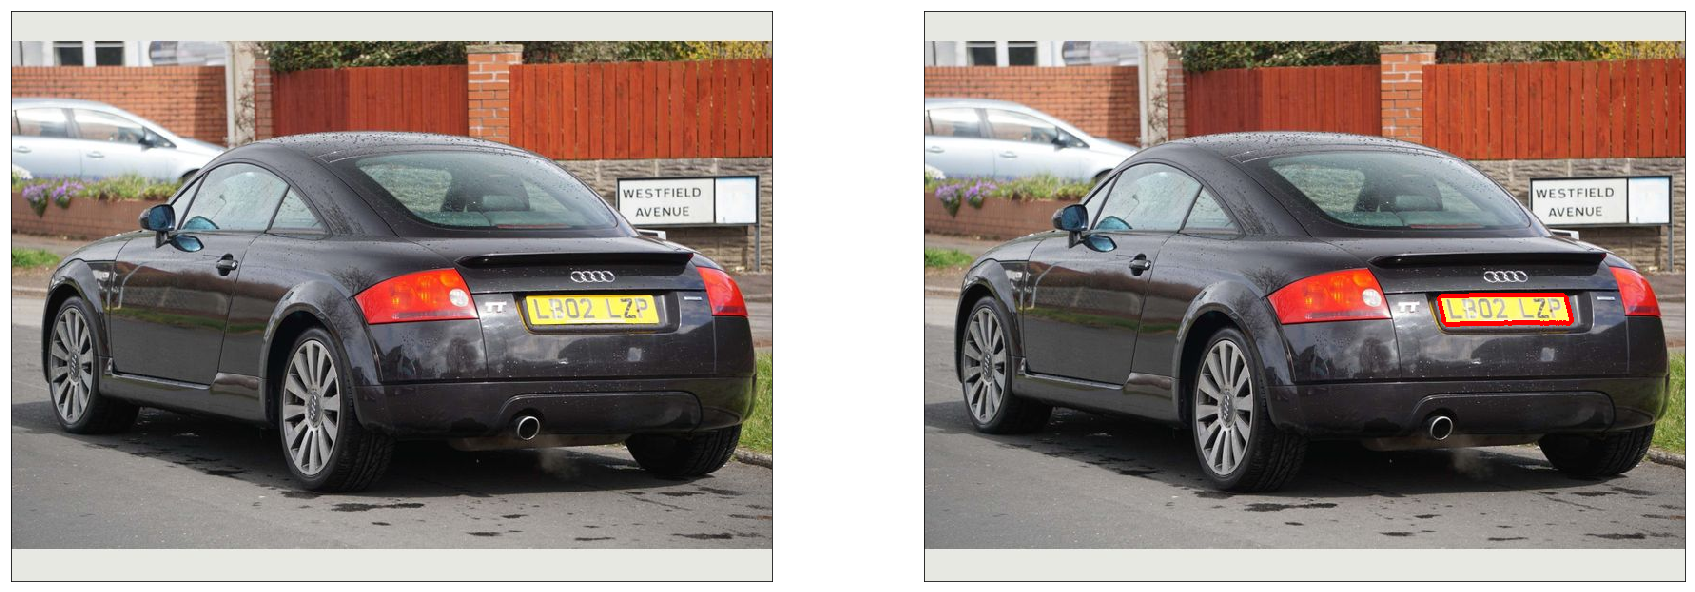

In [164]:

image_copy = image.copy()

for c in contours:
    #
    # Proces contour for numberplate characteristics
    #
    
    # Calcualte the approximate boundary for this contour
    perimeter = cv2.arcLength(c, True)
    approxBoundary = cv2.approxPolyDP(c, 0.015 * perimeter, True)
    area = cv2.contourArea(approxBoundary)
    x,y,w,h = cv2.boundingRect(approxBoundary)

    # Remove anything without 4 courn corners
    if len(approxBoundary) != 4:
        continue;

    # Calc area size and filter out easier ways to do.
    areaSize = cv2.contourArea(approxBoundary)
    if areaSize < 500:
        continue;
        
    isContourConvex = cv2.isContourConvex(approxBoundary)
    if isContourConvex == False:
        continue;

    # Is Rectangle Shape
#     double maxCosine = 0;
#     for( int j = 2; j < 5; j++ ) {
#       double cosine = Math.abs(Utils.determineAngle(points[j % 4], points[j - 2], points[j - 1]));
#       maxCosine = Math.max(maxCosine, cosine);
#     }

#     // if cosines of all angles are small
#     // (all angles are ~90 degree) then write quadrangle
#     // vertices to resultant sequence
#     return maxCosine < 0.3;

    # Draw the contour as a possible match
    plate = image[y:y+h, x:x+w]
    plate_gray = gray[y:y+h, x:x+w]
    cv2.drawContours(image_copy, [c], -1, 255, 3)
    break
plot_images(image, image_copy)

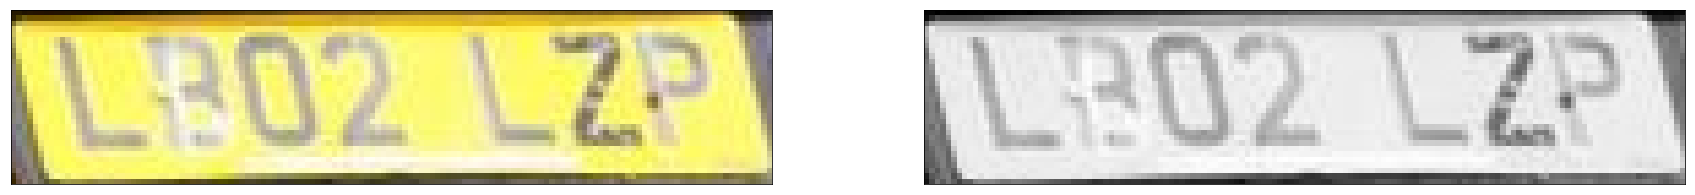

In [175]:
plot_images(plate, plate_gray)

In [176]:
ret, plate_mask = cv2.threshold(plate_gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_images(plate_gray, plate_mask, "Plate (Gray)", "Plate (Binary)")

### Perform OCR on the scropped plate

Now that we have cropped the plate candiate, we can run it through an OCR Trained Neural Network, the current network being used is an english trained network but could be improved by retraining it with the Charles Font which is what the UK plates use, this will help increase accuracy.

In [177]:
text = pytesseract.image_to_string(plate_mask, config='-l eng --psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ')
printmd("# " + text)

# 